###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 parts of this notebook are from [this Jupyter notebook](https://nbviewer.jupyter.org/github/krischer/seismo_live/blob/master/notebooks/Computational%20Seismology/The Finite-Difference Method/fd_ac1d.ipynb) by Heiner Igel ([@heinerigel](https://github.com/heinerigel)), Lion Krischer ([@krischer](https://github.com/krischer)) and Taufiqurrahman ([@git-taufiqurrahman](https://github.com/git-taufiqurrahman)) which is a supplemenatry material to the book [Computational Seismology: A Practical Introduction](http://www.computational-seismology.org/),  additional modifications by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

###### Translated by Huizhe Di @ SCSIO

# 有限差分的稳定性和离散

在上节课中，我们发展了一维声学有限差分正演代码。对于给定的建模参数，代码完美地工作并提供了建模的地震图，这与解析解得到的结果非常一致。在本课中，我们将研究如何选择最佳时间步长dt和空间网格点距离dx，以获得稳定准确的FD建模结果。首先，我们重新审视一维声学有限差分建模代码的简化版本 ...



In [1]:
# Import Libraries 
# ----------------
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Definition of modelling parameters
# ----------------------------------
xmax = 500 # maximum spatial extension of the 1D model (m)
dx   = 0.5 # grid point distance in x-direction

tmax = 1.001   # maximum recording time of the seismogram (s)
dt   = 0.0010  # time step

vp0  = 333.   # P-wave speed in medium (m/s)

# acquisition geometry
xr = 365.0 # receiver position (m)
xsrc = 249.5 # source position (m)

f0   = 25. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift (s)

## 数值与解析解的比较

在下面的函数中，我们通过3点空间/时间差算子求解齐次一维声波方程，并将数值结果与解析解进行比较。为了更多地使用建模参数，我将输入参数限制为dt和dx。空间格网点和时间步长的数量以及离散的源和接收器位置在此函数中估计。

In [3]:
# 1D Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------
def FD_1D_acoustic(dt,dx):
        
    nx = (int)(xmax/dx) # number of grid points in x-direction
    print('nx = ',nx)
        
    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)
    
    ir = (int)(xr/dx)      # receiver location in grid in x-direction    
    isrc = (int)(xsrc/dx)  # source location in grid in x-direction

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of a Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))

    # Analytical solution
    # -------------------
    G    = time * 0.

    # Initialize coordinates
    # ----------------------
    x    = np.arange(nx)
    x    = x * dx       # coordinate in x-direction

    for it in range(nt): # Calculate Green's function (Heaviside function)
        if (time[it] - np.abs(x[ir] - x[isrc]) / vp0) >= 0:
            G[it] = 1. / (2 * vp0)
    Gc   = np.convolve(G, src * dt)
    Gc   = Gc[0:nt]
    lim  = Gc.max() # get limit value from the maximum amplitude
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros(nx) # p at time n (now)
    pold = np.zeros(nx) # p at time n-1 (past)
    pnew = np.zeros(nx) # p at time n+1 (present)
    d2px = np.zeros(nx) # 2nd space derivative of p

    # Initialize model (assume homogeneous model)
    # -------------------------------------------
    vp    = np.zeros(nx)
    vp    = vp + vp0       # initialize wave velocity in model

    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt) 
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):
    
        # FD approximation of spatial derivative by 3 point operator
        for i in range(1, nx - 1):
            d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2

        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp ** 2 * dt ** 2 * d2px

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc] = pnew[isrc] + src[it] / dx * dt ** 2
                
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
    
        # Output of Seismogram
        # -----------------
        seis[it] = p[ir]   
        
    # Compare FD Seismogram with analytical solution
    # ---------------------------------------------- 
    # Define figure size
    rcParams['figure.figsize'] = 12, 5
    plt.plot(time, seis, 'b-',lw=3,label="FD solution") # plot FD seismogram
    Analy_seis = plt.plot(time,Gc,'r--',lw=3,label="Analytical solution") # plot analytical solution
    plt.xlim(time[0], time[-1])
    plt.ylim(-lim, lim)
    plt.title('Seismogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()            

nx =  1000
nt =  1000


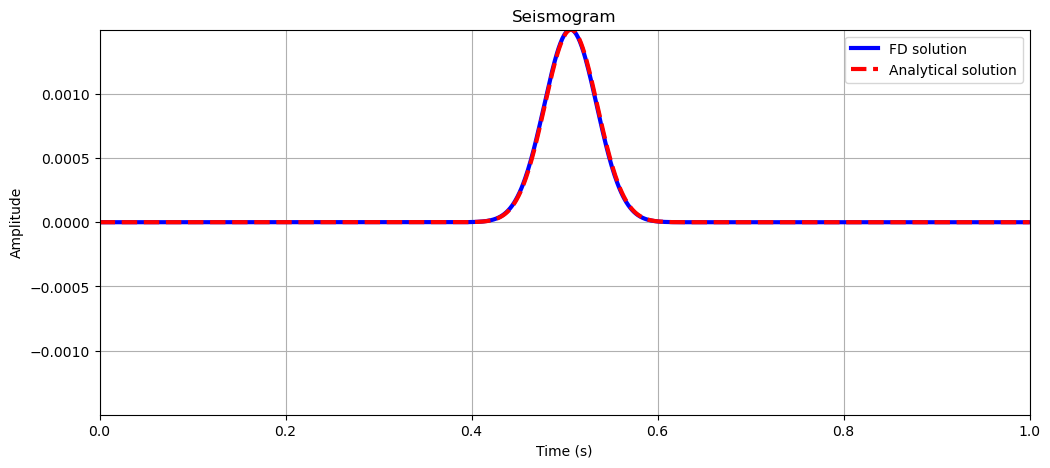

In [4]:
dx   = 0.5 # grid point distance in x-direction
dt   = 0.0010  # time step
FD_1D_acoustic(dt,dx)

这是我们在上一课中取得的相同结果。现在，您可能会想到通过增加时间步长 dt 来节省一些计算时间。让我们尝试一下 ... 

nx =  1000
nt =  666


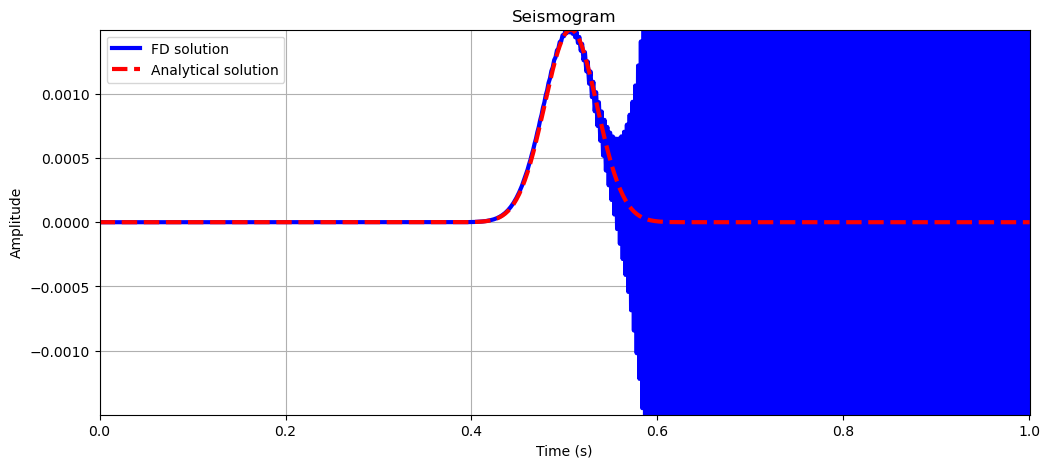

In [5]:
dx   = 0.5 # grid point distance in x-direction
#dt   = 0.0010  # old time step
dt   = 0.0015023  # time step
FD_1D_acoustic(dt,dx)

哎呀，也许这个想法根本不那么聪明，因为建模变得 **不稳定**. 我们可以尝试增加空间离散化dx以节省计算时间，而不是增加时间步长dt ...

nx =  71
nt =  1000


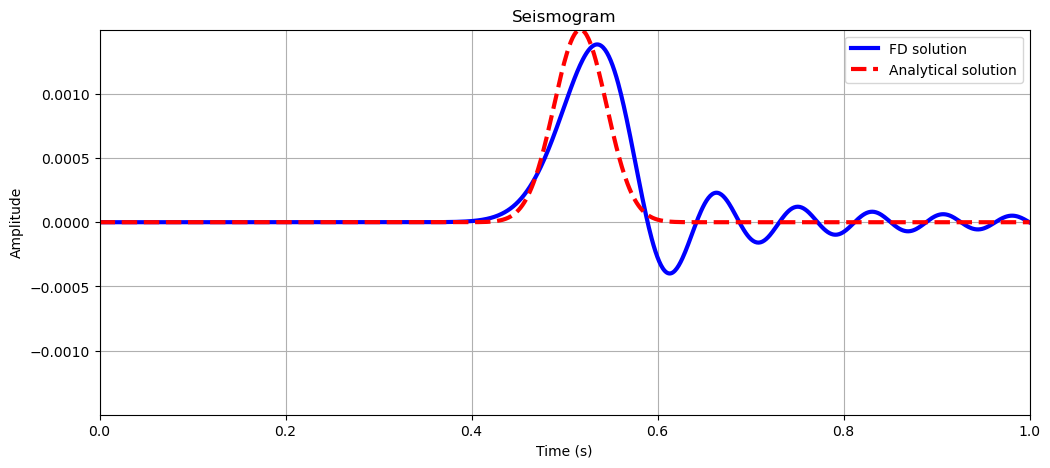

In [7]:
# dx   = 0.5 # old grid point distance in x-direction
dx   = 7.0 # new grid point distance in x-direction
dt   = 0.0010  # time step
FD_1D_acoustic(dt,dx)

嗯，当空间网格点$dx$增加时，与解析解相比，FD建模结果的精确性明显减弱。为什么体波会变得离散呢？更一般地说，如何在不使用试错法的情况下选择$dx$和$dt$，这需要大量的计算时间，尤其是在考虑3D建模时。为了理解潜在的问题，我们将在接下来的两节中研究有限差分方法的稳定性和数值离散。

## 一维声波方程有限差分近似的稳定性

分析一维声波方程有限差分近似的稳定性:

\begin{equation}
 \frac{p_{j}^{n+1} - 2 p_{j}^n + p_{j}^{n-1}}{\mathrm{d}t^2} \ = \ vp_{j}^2 \frac{p_{j+1}^{n} - 2 p_{j}^n + p_{j-1}^{n}}{\mathrm{d}x^2},
\end{equation}

我们使用由著名数学家和计算科学先驱介绍的方法 [John von Neumann](https://en.wikipedia.org/wiki/John_von_Neumann). 对于 **von Neumann Analysis**, 我们假设压力波场的谐波平面波解，如:

\begin{equation}
p = exp(i(kx-\omega t)),\nonumber
\end{equation}

这里 $i^2=-1$, 波数 $k$ 和循环频率y $\omega$. 使用离散空间坐标：

$x_j = j dx,$

和时间： 

$t_n = n dt.$

我们可以计算离散位置和时间的离散平面波解在方程(1), 例如在网格点 j 和时间 n:  

\begin{equation}
p_j^n = exp(i(kjdx-\omega n dt)),\nonumber
\end{equation}

在网格点 j 和时间 n+1:

\begin{align}
p_j^{n+1} &= exp(i(kjdx-\omega (n+1) dt))\nonumber\\
&= exp(-i\omega dt)\; exp(i(kjdx-\omega n dt))\nonumber\\
&= exp(-i\omega dt)\; p_j^n,\nonumber\\
\end{align}

或者在网格点 j 和时间 n-1:

\begin{align}
p_j^{n-1} &= exp(i(kjdx-\omega (n-1) dt))\nonumber\\
&= exp(i\omega dt)\; exp(i(kjdx-\omega n dt))\nonumber\\
&= exp(i\omega dt)\; p_j^n.\nonumber\\
\end{align}

相似的近似可被用来估计时间  n 在空间网格点 j+1:

\begin{align}
p_{j+1}^{n} &= exp(i(k(j+1)dx-\omega n dt))\nonumber\\
&= exp(ik dx)\; exp(i(kjdx-\omega n dt))\nonumber\\
&= exp(ik dx)\; p_j^n,\nonumber\\
\end{align}

在网格点 j-1:

\begin{align}
p_{j-1}^{n} &= exp(i(k(j-1)dx-\omega n dt))\nonumber\\
&= exp(-ik dx)\; exp(i(kjdx-\omega n dt))\nonumber\\
&= exp(-ik dx)\; p_j^n.\nonumber\\
\end{align}

把这些离散化的压力波场解 $p_j^{n+1}$, $p_j^{n-1}$, $p_{j+1}^{n}$ 和 $p_{j-1}^{n}$ 导入方程(1)中, 经过变换，我们得到:

\begin{equation}
exp(-i\omega dt)p_j^n - 2 p_j^n + exp(i\omega dt)p_j^n = vp_j^2 \frac{dt^2}{dx^2}\biggl(exp(-ik dx)p_j^n - 2 p_j^n + exp(ik dx)p_j^n\biggr).\nonumber
\end{equation}

假设 $p_j^n \ne 0$, 我们可以划分 RHS 和 LHS 通过 $p_j^n$

\begin{equation}
exp(-i\omega dt) - 2 + exp(i\omega dt) = vp_j^2 \frac{dt^2}{dx^2}\biggl(exp(-ik dx) - 2 + exp(ik dx)\biggr).\nonumber
\end{equation}

进一步划分 RHS 和 LHS 通过 2, 我们得到:

\begin{equation}
\frac{exp(i\omega dt) + exp(-i\omega dt)}{2} - 1 = vp_j^2 \frac{dt^2}{dx^2}\biggl(\frac{exp(ik dx) + exp(-ik dx)}{2} - 1\biggr).\nonumber
\end{equation}

使用定义

\begin{equation}
\cos(x) = \frac{exp(ix) + exp(-ix)}{2},\nonumber
\end{equation}

我们可以简化这个表达为:

\begin{equation}
cos(\omega dt) - 1 = vp_j^2 \frac{dt^2}{dx^2}\biggl(cos(k dx) - 1\biggr).\nonumber
\end{equation}

经过进一步的重新排列和双方的2分割，得到:

\begin{equation}
\frac{1 - cos(\omega dt)}{2} = vp_j^2 \frac{dt^2}{dx^2}\biggl(\frac{1 - cos(k dx)}{2}\biggr).\nonumber
\end{equation}

与关系 

\begin{equation}
sin^2\biggl(\frac{x}{2}\biggr) = \frac{1-cos(x)}{2}, \nonumber
\end{equation}

我们得到 

\begin{equation}
sin^2\biggl(\frac{\omega dt}{2}\biggr) = vp_j^2 \frac{dt^2}{dx^2}\biggl(sin^2\biggl(\frac{k dx}{2}\biggr)\biggr).\nonumber
\end{equation}

取两边的平方根最终得到 

\begin{equation}
sin\frac{\omega dt}{2} = vp_j \frac{dt}{dx}\biggl(sin\frac{k dx}{2}\biggr).
\end{equation}

这个结果相当有趣. 注意, sine $sin(x)$ 函数的振幅在 LHS 和 RHS 变化范围为 -1 和 1. 然而, 如果 RHS 的系数

\begin{equation}
\epsilon = vp_j \frac{dt}{dx} \nonumber
\end{equation}

大于1 ($\epsilon>1$), 你得到的只有虚构的解决方案, 而实际部分为零. 因此，数值方案变得不稳定。因此，标准

\begin{equation}
\epsilon = vp_j \frac{dt}{dx} \le 1 \nonumber
\end{equation}

不得不满足. 这个非常重要的稳定性标准首先由德裔美国数学家理乍得·库兰特，库尔特·弗里德里希斯和汉斯·路易描述在 [this paper](https://gdz.sub.uni-goettingen.de/id/PPN235181684_0100?tify={%22pages%22:[36],%22view%22:%22thumbnails%22}) from 1928. 这个 **Courant-Friedrichs-Lewy criterion** 简称为 **CFL-criterion**, 也可以重新排列为时间步长dt，假设我们已经定义了一个空间网格点距离dx:

\begin{equation}
dt  \le \frac{dx}{vp_j}. \nonumber
\end{equation}

此标准仅适用于使用 3 点空间/时间有限差分算子和显式时间步进方案的一维声学波动方程的有限差分解

更一般地说，我们可以 Courant criterion 写成

\begin{equation}
dt  \le \frac{dx}{\zeta vp_j}, \nonumber
\end{equation}

这里，系数 $\zeta$ 依赖于使用的 FD 算子, 问题的维度 (1D, 2D, 3D) 和整体的算法. 即使 CFL criterion 严格依赖于 P-wave 速度在一个特定的网格点上, 在大多数情况下，介质中的最大速度 $v_{max}$ 被用来估计一个常时间步长 $dt$ 对于整个的有限差分建模:

\begin{equation}
dt  \le \frac{dx}{\zeta v_{max}}, \nonumber
\end{equation}

这里 $v_{max}$ 是最大的 P-wave 速度在声学情况下或者最大的 S-wave 速度在 SH-problem. 虽然满足CFL criterion 可以带来稳定的模拟，但它并不能保证准确的建模结果 

CFL criterion 让我们能估计一个合适的步长 dt 基于模型中的最大速度和空间网格点的距离. 但是，我们如何去选择空间网格点的距离 dx 呢?

## 数值网格的离散

在这个 Jupyter notebook 的开始, 我们已经看到，当选择过大的空间网格点距离时，建模的波场可能会受到离散的影响。von Neumann analysis 的结果可用来解释这个现象. 从方程 (2) 开始

\begin{equation}
sin\frac{\omega dt}{2} = \epsilon\; sin\frac{k dx}{2}, \nonumber
\end{equation}

我们对等式两边同时取 $arcsin$

\begin{equation}
\frac{\omega dt}{2} = arcsin\biggl(\epsilon\; sin\frac{k dx}{2} \biggr)\nonumber
\end{equation}

再同时乘以 $\frac{2}{dt}$, 我们得到

\begin{equation}
\omega = \frac{2}{dt}arcsin\biggl(\epsilon\; sin\frac{k dx}{2}\biggr)\nonumber
\end{equation}

将 $\omega-k$ 关系导入到相速度的定义中

\begin{equation}
v_{phase} = \frac{\omega}{k},\nonumber
\end{equation}

leads to 

\begin{equation}
v_{phase} = \frac{2}{k dt}arcsin\biggl(\epsilon\; sin\frac{k dx}{2}\biggr).\nonumber
\end{equation}

可以看到, 有限差分数值解的相速度是波数 k 的一个函数. 因此, 它是有频散的. 为了进一步探讨这个问题, 我们重写相速度.

通过波数 $k=\frac{2 \pi}{\lambda}$, 这里 $\lambda$ 表示波长, 我们得到:

\begin{equation}
v_{phase} = \frac{\lambda}{\pi dt}arcsin\biggl(\epsilon\; sin\frac{\pi dx}{\lambda}\biggr).\nonumber
\end{equation}

从定义 $\epsilon = vp_0 \frac{dt}{dx}$, 我们可以吧 $dt$ 替换为 $dt = \frac{\epsilon dx}{vp_0}$ 在相速度中:

\begin{equation}
v_{phase} = \frac{\lambda vp_0}{\pi \epsilon dx}arcsin\biggl(\epsilon\; sin\frac{\pi dx}{\lambda}\biggr).\nonumber
\end{equation}

引入**每个波长的网格点数** $N_\lambda = \frac{\lambda}{dx}$, 我们最终得到:

\begin{equation}
v_{phase} = \frac{N_\lambda vp_0}{\pi \epsilon}arcsin\biggl(\epsilon\; sin\frac{\pi }{N_\lambda}\biggr).\nonumber
\end{equation}

让我们画出结果 $N_\lambda$ 从 2 到 12, 均匀的P波速度 $vp0\;=\;333\;m/s$, 和 $\epsilon$ 值 从 0.7 到 1.0 ...

In [10]:
Nwave = np.arange(2,12,0.25) # numbers per wavelength
vp0 = 333.0 # P-wave velocity (m/s)

def dispersion_1D(eps):
    
    vp_phase = (vp0*Nwave/(np.pi*eps)) * np.arcsin(eps*np.sin(np.pi/Nwave)) 
    
    return vp_phase

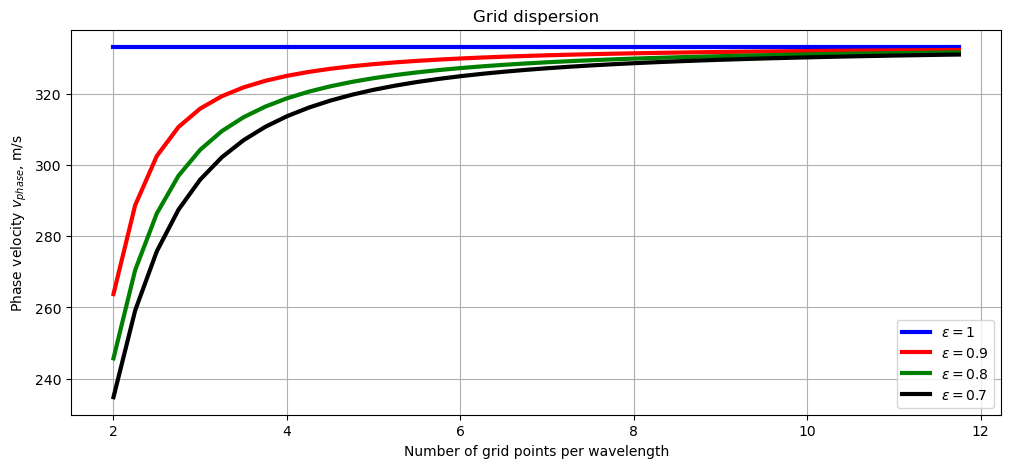

In [11]:
vp_eps_1 = dispersion_1D(1.0)
vp_eps_2 = dispersion_1D(0.9)
vp_eps_3 = dispersion_1D(0.8)
vp_eps_4 = dispersion_1D(0.7)

plt.plot(Nwave, vp_eps_1, 'b-',lw=3,label=r"$\epsilon=1$")
plt.plot(Nwave, vp_eps_2, 'r-',lw=3,label=r"$\epsilon=0.9$") 
plt.plot(Nwave, vp_eps_3, 'g-',lw=3,label=r"$\epsilon=0.8$") 
plt.plot(Nwave, vp_eps_4, 'k-',lw=3,label=r"$\epsilon=0.7$") 
plt.title('Grid dispersion')
plt.xlabel('Number of grid points per wavelength')
plt.ylabel('Phase velocity $v_{phase}$, m/s')
plt.legend()
plt.grid()
plt.show() 

注意到, 在 $\epsilon=1$ 时没有频散发生. 但请记住，这仅适用于均质介质。现实建模问题具有可变的 P 波速度, 因此，我们在模型中的 $\epsilon$ 是变化的.

对于所有 $\epsilon<1$, 数值离散可能会发生, 如果模型的空间采样太小, 特别在 Nyquist criterion $N_\lambda = 2$. 对于一维声学波动方程, 频散在 $N_\lambda$ 为 8-12 时最小.

更加普遍, 我们可以定义 **grid dispersion criterion** 对于空间采样距离

\begin{equation}
dx \le \frac{\lambda_{min}}{N_\lambda} = \frac{v_{min}}{N_\lambda f_{max}},\nonumber
\end{equation}

这里 $N_\lambda$ 依赖于使用的 FD 算子, 数值方案和波的类型, $v_{min}$ 表示模型中最小的 P- or S-wave 速度， $f_{max}$ 地震子波的最大频率. 

最后，让我们将离散和稳定性标准应用于我们的测试问题，以便找到最佳的dt和dx值 ...

dx =  0.555
epsilon =  1.0
dt =  0.0016666666666666668
nx =  900
nt =  600


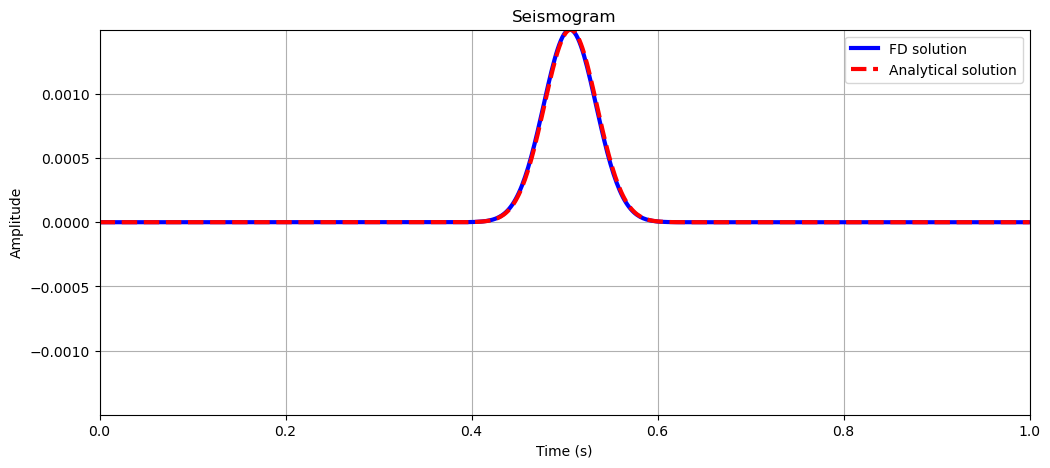

In [12]:
# calculate dx according to the grid dispersion criterion
Nlam = 12              # number of grid points per wavelength
fmax = 50.0            # fmax = 2 * f0 (Hz)
dx = vp0 / (Nlam*fmax) # spatial gridpoint distance (m)
print('dx = ', dx)

# calculate dt according to the CFL criterion
dt = dx / vp0 # time step (s)

# check CFL criterion
epsilon = vp0 * dt / dx
print('epsilon = ', epsilon)
if(epsilon>1.0):
    print('Warning: CFL condition is violated!')
print('dt = ', dt)

FD_1D_acoustic(dt,dx)

## 我们学习到:

* 估计 Courant-Friedrichs-Lewy (CFL) stability criterion $dt  \le \frac{dx}{v_{max}}$ 对于一维声学波动方程使用 von Neumann analysis
* 一维声学波动方程的频散分析
* Grid dispersion criterion: $dx \le \frac{v_{min}}{N_\lambda f_{max}}$
* 优化有限差分模拟参数通过 grid dispersion 和 CFL conditions